In [3]:
from pprint import pprint
from convertmol import parse_sdf_file, bond_type_dict, single_bond_stereo_dict, double_bond_stereo_dict
from torch_geometric.data import Data, DataListLoader, Dataset, InMemoryDataset, Batch
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.nn import *
from torch_geometric.nn.models import SchNet,DimeNetPlusPlus
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops, remove_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm.auto import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from copy import deepcopy
#from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Union
from torch import Tensor
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops, degree
from torch_scatter import scatter
from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from rdkit import Chem
import os
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
cuda=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
import sascorer
#torch.set_default_dtype(torch.float64)
from models import *
from rdkit.Chem.Crippen import MolLogP
from typing import List

In [4]:
ATOMIC_SYMBOL = {
    'H':0, 'He': 1, 'Li': 2, 'Be': 3, 'B': 4, 'C': 5, 'N': 6, 'O': 7, 'F': 8, 'Ne': 9, 
    'Na': 10, 'Mg': 11, 'Al': 12, 'Si': 13, 'P': 14, 'S': 15, 'Cl': 16, 'Ar': 17, 
    'K': 18, 'Ca': 19, 'Sc': 20, 'Ti': 21, 'V': 22, 'Cr': 23, 'Mn': 24, 'Fe': 25, 
    'Co': 26, 'Ni': 27, 'Cu': 28, 'Zn': 29, 'Ga': 30, 'Ge': 31, 'As': 32, 'Se': 33, 
    'Br': 34, 'Kr': 35, 'Rb': 36, 'Sr': 37, 'Y': 38, 'Zr': 39, 'Nb': 40, 'Mo': 41, 
    'Tc': 42, 'Ru': 43, 'Rh': 44, 'Pd': 45, 'Ag': 46, 'Cd': 47, 'In': 48, 'Sn': 49, 
    'Sb': 50, 'Te': 51, 'I': 52, 'Xe': 53, 'Cs': 54, 'Ba': 55, 'La': 56, 'Ce': 57, 
    'Pr': 58, 'Nd': 59, 'Pm': 60, 'Sm': 61, 'Eu': 62, 'Gd': 63, 'Tb': 64, 'Dy': 65, 
    'Ho': 66, 'Er': 67, 'Tm': 68, 'Yb': 69, 'Lu': 70, 'Hf': 71, 'Ta': 72, 'W ': 73, 
    'Re': 74, 'Os': 75, 'Ir': 76, 'Pt': 77, 'Au': 78, 'Hg': 79, 'Tl': 80, 'Pb': 81, 
    'Bi': 82, 'Po': 83, 'At': 84, 'Rn': 85, 'Fr': 86, 'Ra': 87, 'Ac': 88, 'Th': 89, 
    'Pa': 90, 'U': 91, 'Np': 92, 'Pu': 93, 'Am': 94, 'Cm': 95, 'Bk': 96, 'Cf': 97, 
    'Es': 98, 'Fm': 99, 'Md': 100, 'No': 101, 'Lr': 102, 'Rf': 103, 'Db': 104, 'Sg': 105, 
    'Bh': 106, 'Hs': 107, 'Mt': 108, 'Ds': 109, 'Rg': 110, 'Cn': 111, 'Nh': 112, 'Fl': 113, 
    'Mc': 114, 'Lv': 115, 'Ts': 116, 'Og': 117
}

In [5]:
BONDTYPE= {
    'UNSPECIFIED': 0,
    'SINGLE': 1,
    'DOUBLE': 2,
    'TRIPLE': 3,
    'QUADRUPLE': 4,
    'QUINTUPLE': 5,
    'HEXTUPLE': 6,
    'ONEANDAHALF': 7,
    'TWOANDAHALF': 8,
    'THREEANDAHALF': 9,
    'FOURANDAHALF': 10,
    'FIVEANDAHALF': 11,
    'AROMATIC': 12,
    'IONIC': 13,
    'HYDROGEN': 14,
    'THREECENTER': 15,
    'DATIVEONE': 16,
    'DATIVE': 17,
    'DATIVEL': 18,
    'DATIVER': 19,
    'OTHER': 20,
    'ZERO': 21,
    'SELF':22,
}

bca,bc,ce->bae

$H_{bae}=E_{bca}A_{bc}X_{ce}$

In [6]:
DIST_MEAN=1.45
DIST_STD=0.1

In [7]:
class MolData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if 'index' in key:
            return self.num_nodes
        elif key=='dest' or key=='inbound':
            return self.num_edges
        else:
            return 0
    
    def __cat_dim__(self, key, value, *args, **kwargs):
        if 'index' in key:
            return 1
        else:
            return 0

In [8]:

class QM9(InMemoryDataset):
    raw_url = ('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/'
               'molnet_publish/qm9.zip')
    raw_url2 = 'https://ndownloader.figshare.com/files/3195404'
    processed_url = 'https://data.pyg.org/datasets/qm9_v3.zip'

    def __init__(
        self,
        root: str,
        transform = None,
        pre_transform = None,
        pre_filter = None,
        force_reload = False,
    ) -> None:
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> List[str]:
        return ['gdb9.sdf','gdb9.sdf.csv']

    @property
    def processed_file_names(self) -> str:
        return ['gdb9_processed.pt']

    def download(self) -> None:
        try:
            import rdkit  # noqa
            file_path = download_url(self.raw_url, self.raw_dir)
            extract_zip(file_path, self.raw_dir)
            os.unlink(file_path)

            file_path = download_url(self.raw_url2, self.raw_dir)
            os.rename(os.path.join(self.raw_dir, '3195404'),
                      os.path.join(self.raw_dir, 'uncharacterized.txt'))
        except ImportError:
            path = download_url(self.processed_url, self.raw_dir)
            extract_zip(path, self.raw_dir)
            os.unlink(path)
    
    def process(self) -> None:
        suppl = Chem.SDMolSupplier(self.raw_paths[0])
        df = pd.read_csv(self.raw_paths[1])
        data_list = list()
        for i, (mol, (_, y_row)) in enumerate(zip(tqdm(suppl), df.iterrows())):
            if isinstance(mol, rdkit.Chem.Mol):
                d=Data(mol=mol)
                for k in y_row.index:
                    if k=='mol_id': continue
                    d[k]=float(y_row[k])
                data_list.append(process_molecule_sparse(d))
        self.save(data_list, self.processed_paths[0])

In [9]:
def find_perpendicular_vectors(X):
    if X.shape[0]==0:
        return X.detach().clone()
    # Use a reference vector that is not collinear with most vectors
    ref_vector = torch.tensor([1.234334662475, -0.523246582678, -0.913510345611], device=X.device).repeat(X.size(0), 1)
    
    # Handle edge cases where X is parallel to ref_vector ([a, 0, 0] case)
    #parallel_mask = (X[:, 0] != 0) & (X[:, 1] == 0) & (X[:, 2] == 0)
    #ref_vector[parallel_mask] = torch.tensor([0.0, 1.0, 0.0], device=X.device)

    # Compute orthogonal vectors using cross product
    U = torch.cross(X, ref_vector, dim=-1)
    V = torch.cross(X, U, dim=-1)
    U /= torch.linalg.norm(U,ord=2,dim=-1).view(-1,1)
    V /= torch.linalg.norm(V,ord=2,dim=-1).view(-1,1)
    
    return U,V

In [10]:
def find_matching_pairs(A, B, deg_out):
    'returns a [2,N] list L wherein L[i] = (a,b) and A[a]==B[b]'
    common_values = torch.unique(A)

    matching_pairs = []

    for value in common_values:
        # Indices in A where the value occurs
        indices_A = torch.nonzero((A == value) & (A != B) & (deg_out[A]>3), as_tuple=True)[0]
        # Indices in B where the value occurs
        indices_B = torch.nonzero((B == value) & (A != B), as_tuple=True)[0]

        # Compute the Cartesian product of indices_A and indices_B
        cartesian_product = torch.cartesian_prod(indices_A, indices_B)
        matching_pairs.append(cartesian_product)

    # Step 5: Concatenate all pairs into a single tensor
    if matching_pairs:
        Y = torch.cat(matching_pairs, dim=0)
    else:
        Y = torch.empty((0, 2), dtype=torch.long, device=A.device)  # No matches found

    return Y.T


In [11]:
def batch_tranform(batch):
    X=batch.atom_type
    A=batch.edge_index
    #E=batch.edge_attr
    T=batch.edge_type#E[:,0]#typ
    D=batch.D#E[:,2:5]#delta (bond vector)
    U=batch.U#E[:,5:8]
    V=batch.V#E[:,8:11]
    #b=batch.batch
    y=batch.y
    # return [2,n] list 
    Y=find_matching_pairs(A[0], A[1], degree(A[1], X.shape[0]))
    ## assert (Y==Y[:,Y[0]!=Y[1]]).all()
    # remove "flipped anchor bond"  (they exist because the graph is undirected, and they are colinear with the anchor bond)
    Y=Y[:,~(A[:,Y[1]].flip(0)==A[:,Y[0]]).all(0)]
    if Y.numel()==0:
        #dest=[12], inbound=[12, 2], ang_deltas=[12]
        batch.dest=torch.empty(size=(0,),device=Y.device).long()
        batch.inbound=torch.empty(size=(0,2),device=Y.device).long()
        batch.ang_deltas=torch.empty(size=(0,),device=Y.device)
        batch.anchor_ang=torch.empty(size=(0,),device=Y.device)
        return batch
    anchor_angles_u=torch.cross(D[Y[0]], D[Y[1]]+torch.randn_like(D[Y[1]])*1e-10, dim=-1)
    anchor_angles_v=torch.cross(anchor_angles_u, D[Y[0]], dim=-1)#https://study.com/cimages/videopreview/videopreview-full/5zsq17tjsc.jpg
    anchor_angles_w=D[Y[0]]/torch.linalg.norm(D[Y[0]],ord=2,dim=-1).view(-1,1)#torch.linalg.norm(anchor_angles_u,ord=2,dim=-1).view(-1,1)
    anchor_angles_v/=torch.linalg.norm(anchor_angles_v,ord=2,dim=-1).view(-1,1)
    x_proj = -(anchor_angles_w*D[Y[1]]).sum(-1)
    y_proj = (anchor_angles_v*D[Y[1]]).sum(-1)
    anchor_ang=1.5708-torch.atan2(x_proj, y_proj)#anchor_ang is the angle between each incoming bond of an anchor bond and the anchor bond itself
    # calculate projected x
    u=(U[Y[0]]*D[Y[1]]).sum(-1)
    # calculate projected y
    v=(V[Y[0]]*D[Y[1]]).sum(-1)
    # calculate angle (radian)
    ang=torch.atan2(u,v)#ang is the angle between each pair of bonds that is connected to an anchor bond
    # get sorted index based on the angle (this is needed because the convolution goes 'around' the anchor axis)
    sorted_idx=(Y[0]*2*torch.pi+ang).argsort()
    # helper variables
    ang_sorted=ang[sorted_idx]
    Y_sorted=Y[:,sorted_idx]
    # groups is [a,b,c...] wherein each member is an index representing the end index of each group
    # what is a group?
    # assume Y is 
    # 10 10 10 11 11 12 12
    # 15 16 17 12 13 14 15
    # which means bond#10 is coming OUT from a chiral center, which have 3 bonds connecting INTO it.
    # bond#10, in this context, for the first 3 entry in Y from the left. is an anchor bond, also called a "group"
    # however, since the graph is undirected, bond#15 might be the flipped bond, which is colinear 
    # we don't want rotate around every other bond, which means we remove the flipped anchor bond
    # in the example above, there would be 3 groups whose end-index would be 2,4
    # whenever there is G groups, there len(groups) == G-1
    # which is why we concat -1 to it, representing the end=index of the final group
    groups=Y_sorted[0].diff().nonzero()[:,0]
    groups=torch.cat([groups,torch.tensor([-1],device=groups.device)])
    # `idx` explaination:
    # idx is a [2,N] matrix containing circular-pairwise indeces for every group
    # which, continuing from previous part, idx would be
    # 0 1 2 3 4 5 6
    # 1 2 0 4 3 6 5
    try:
        idx=torch.arange(Y.shape[-1], device=Y.device).repeat(2).view(2,-1)
        idx[1]=idx[0].roll(-1)
        idx[1,groups]=(groups+1).roll(1)
    except Exception as e:
        print("idx:",idx.shape)
        print("idx=",idx)
        print("groups:",groups.shape)
        print("groups=",groups)
        print("Y:",Y.shape)
        print("Y=",Y)
        raise e
    inbound=Y_sorted[1,idx.T]
    ang_deltas=((ang_sorted[idx].T.diff() + torch.pi) % (2 * torch.pi) - torch.pi).abs()
    dest=Y_sorted[0,None].T
    batch.dest=dest.squeeze(-1)
    batch.inbound=inbound
    batch.ang_deltas=ang_deltas.squeeze(-1) 
    batch.anchor_ang=anchor_ang.squeeze(-1) 
    return batch

In [12]:
DEFAULT_TYPE=torch.tensor([]).dtype
def process_molecule_sparse(data: Data):
    m = data.mol
    conf: Chem.Conformer=m.GetConformer()
    atoms: List[Chem.Atom]=m.GetAtoms()
    bonds = m.GetBonds()
    Nv=len(atoms)
    Ne=len(bonds)
    atom_type=torch.zeros(Nv).long()
    P=torch.empty(Nv, 3, dtype=DEFAULT_TYPE)
    A=[]
    edge_type=[]
    logp=MolLogP(m)
    #pos=dict()
    for idx,atom in enumerate(atoms):
        atom_type[idx]=ATOMIC_SYMBOL[atom.GetSymbol()]
        #pos[idx]=conf.GetAtomPosition(idx)
        edge_type.append(BONDTYPE['SELF'])
        A.append([idx,idx])
        p=conf.GetAtomPosition(idx)
        P[idx]=torch.tensor([p.x,p.y,p.z])
    for bond in bonds:
        i=bond.GetBeginAtomIdx()
        j=bond.GetEndAtomIdx()
        typ=BONDTYPE[str(bond.GetBondType())]
        
        A.append([i,j])
        A.append([j,i])
        
        
        edge_type.append(typ)
        edge_type.append(typ)
    edge_type=torch.tensor(edge_type)
    A=torch.tensor(A).long()
        
    D = P[A[:,1]]-P[A[:,0]]
    U,V=find_perpendicular_vectors(D)
    dist=((torch.linalg.norm(D,ord=2,dim=-1)-DIST_MEAN)/DIST_STD).view(-1,1)
    #E=torch.cat([E,dist,D,U,V],-1)
    ret=MolData(atom_type=atom_type,edge_index=A.T,edge_type=edge_type,dist=dist,D=D,U=U,V=V,logp=logp,pos=P)
    for k in data.keys():
        if k!='mol':
            ret[k]=data[k]
    return batch_tranform(ret)

In [13]:
def transform(data):
    #print("ayo",data)
    ret= process_molecule_sparse(data)
    #print("ret",ret)
    return ret

In [14]:
sup=Chem.SDMolSupplier("gdb9.sdf")

In [15]:
qm9=QM9("datasets/")

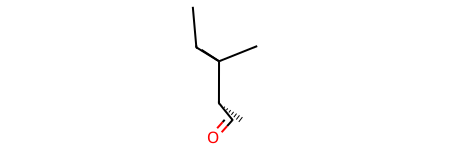

In [16]:
sample_idx=100_000
sample=qm9[sample_idx]
sup[sample_idx]

In [66]:
sei=sample.edge_index
print(sei.shape)
sei

torch.Size([2, 25])


tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 6, 8, 6, 7, 4, 6, 2, 3, 2, 4, 4, 5, 1, 2, 0,
         1],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 6, 7, 6, 6, 4, 3, 2, 4, 2, 5, 4, 2, 1, 1,
         0]])

In [67]:
rei=radius_graph(sample.pos, 3)
print(rei.shape)
rei

torch.Size([2, 40])


tensor([[1, 2, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 6, 1, 2, 4, 1, 2, 3, 5, 6, 7, 8, 1,
         2, 4, 6, 7, 2, 4, 5, 7, 8, 4, 5, 6, 8, 4, 6, 7],
        [0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5,
         5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8]])

In [93]:
sample.edge_type.shape,sei.shape

(torch.Size([25]), torch.Size([2, 25]))

In [68]:
(rei.T.unsqueeze(-2)==sei.T.unsqueeze(-3)).all(-1).nonzero()

tensor([[ 0, 24],
        [ 2, 23],
        [ 3, 22],
        [ 8, 21],
        [ 9, 16],
        [10, 18],
        [14, 15],
        [17, 17],
        [19, 20],
        [20, 14],
        [25, 19],
        [29, 13],
        [31, 12],
        [32, 10],
        [35, 11],
        [38,  9]])

In [87]:
sei_idx

tensor([38, 32, 35, 31, 29, 20, 14,  9, 17, 10, 25, 19,  8,  3,  2,  0])

In [88]:
tmp=(rei.unsqueeze(-2)==sei.unsqueeze(-1)).all(0).nonzero()
rei_idx=tmp[:,1]
sei_idx=tmp[:,0]
rei_idx

tensor([38, 32, 35, 31, 29, 20, 14,  9, 17, 10, 25, 19,  8,  3,  2,  0])

In [61]:
rei.shape,sei.shape

(torch.Size([40, 2]), torch.Size([25, 2]))

In [94]:
bl=DataLoader(qm9, batch_size=64, )

In [95]:
import py3Dmol

def show(mol, style='stick'):
    mblock = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=200, height=200)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()
    
# example
show(sup[220])  # or 'P'

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

,count,mean,std,min,25%,50%,75%,max
A,133885.0,9.814382,1809.465666,0.000000,2.554430,3.090360,3.835820,619867.683140
B,133885.0,1.406097,1.583795,0.337120,1.091630,1.369940,1.653980,437.903860
C,133885.0,1.124921,1.095618,0.331180,0.910480,1.078560,1.279540,282.945450
mu,133885.0,2.706037,1.530394,0.000000,1.588700,2.500000,3.636100,29.556400
alpha,133885.0,75.191296,8.187793,6.310000,70.380000,75.500000,80.520000,196.620000
homo,133885.0,-0.239977,0.022131,-0.428600,-0.252500,-0.241000,-0.228700,-0.101700
lumo,133885.0,0.011124,0.046936,-0.175000,-0.023800,0.012000,0.049200,0.193500
gap,133885.0,0.251100,0.047519,0.024600,0.216300,0.249400,0.288200,0.622100
r2,133885.0,1189.527450,279.757172,19.000200,1018.322600,1147.585800,1308.816600,3374.753200
zpve,133885.0,0.148524,0.033274,0.015951,0.125289,0.148329,0.171150,0.273944


(-380.1364430652005, 226.3763836451994)

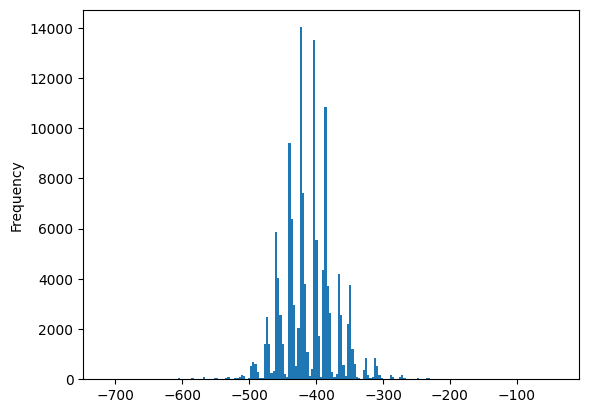

In [96]:
df=pd.read_csv("gdb9.sdf.csv")
display(df.describe().T)
YCOL='u0'
#(df[YCOL].quantile([.01,.02,.03,.05,.5,.95,.97,.98,.99]))
__min=df[YCOL].quantile(.0001)
__max=df[YCOL].quantile(.9999)
__mean=df[YCOL].mean()
__std=df[YCOL].std()
df[YCOL].plot.hist(bins=200)
offset=(__min+__max)/2
width=abs(__max-__min)/2
offset,width

In [17]:
from models.rgin import RGIN
rgin=RGIN(
    atom_emb_i=len(ATOMIC_SYMBOL),
    atom_emb_o=15,
    node_dimses=[
        [15,50,50],
        [50,50,25],
        [25,40,25],
        [25,40,25],
        [25,30,25],
        [25,30,20],
        [20,30,15],
        [15,30,10],
        [10,30,1],
    ],
    edge_dimses=[
        [22,10,5],
        [22,10,5],
        [22,10,5],
        [22,10,5],
        [22,10,5],
        [22,10,5],
        [22,10,5],
    ],
    bond_emb_i=len(BONDTYPE),
    bond_emb_o=22,
    l_atom_emb_i=len(ATOMIC_SYMBOL),
    l_atom_emb_o=15,
    r_atom_emb_i=len(ATOMIC_SYMBOL),
    r_atom_emb_o=15,
    orig_atom_emb_i=len(ATOMIC_SYMBOL),
    orig_atom_emb_o=15,
    dest_atom_emb_i=len(ATOMIC_SYMBOL),
    dest_atom_emb_o=15,
    l_bond_emb_i=len(BONDTYPE),
    l_bond_emb_o=22,
    r_bond_emb_i=len(BONDTYPE),
    r_bond_emb_o=22,
    anchor_bond_emb_i=len(BONDTYPE),
    anchor_bond_emb_o=22,
    ring_agg_inner_dims=[50,64],
    ring_agg_o=22,
    edge_combiner_inner_dims=[50,64],
    edge_combiner_o=22,
    dropout_rate=0.01,
    aggr='sum',
).to(cuda)
rgin_optimizer=torch.optim.AdamW(rgin.parameters())
sum(map(torch.numel,rgin.parameters()))

107736

In [132]:
from models import schnetplusplus
reload(schnetplusplus)

<module 'models.schnetplusplus' from 'C:\\Users\\umarzein\\Desktop\\biocheminformatics\\models\\schnetplusplus.py'>

In [133]:
from models.schnet import SchNet

schnet=SchNet().to(cuda)
schnet_optimizer=torch.optim.AdamW(schnet.parameters())
sum(map(torch.numel,schnet.parameters()))

455809

In [134]:
from models.schnetplusplus import SchNetPlusPlus

schnet2=SchNetPlusPlus().to(cuda)
schnet2_optimizer=torch.optim.AdamW(schnet2.parameters())
sum(map(torch.numel,schnet2.parameters()))

476687

In [135]:
import numpy as np
BATCH_SIZE=64
N_EPOCHS=100
N_mols=len(qm9)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE))
e_bar=tqdm(range(N_mols//BATCH_SIZE))
running_loss_schnet=0
running_loss_schnet2=0
RESET_RECORD=True
UPDATE_RECORD=True
TRAINING=True
results_schnet=[]
results_schnet2=[]
truths=[]
if RESET_RECORD:
    if not TRAINING:
        raise Exception("invalid combination of options")
    record_loss_schnet=[]
    record_loss_schnet2=[]
    total_iters=0
if TRAINING:
    schnet=schnet.train()
    schnet2=schnet2.train()
else:
    schnet=schnet.eval()
    schnet2=schnet2.eval()


for epoch in range(N_EPOCHS):
    e_bar.refresh()
    e_bar.reset(N_mols//BATCH_SIZE)
    bl=DataLoader(qm9, batch_size=BATCH_SIZE, shuffle=True)
    for i, batch in zip(range(N_mols//BATCH_SIZE), bl):
        long_bar.update(1)
        e_bar.update(1)
        if TRAINING:
            total_iters+=1
        try:
            batch=(batch.to(cuda))
            y=(batch[YCOL]-__mean)/__std
            
            ### train schnet
            if TRAINING:
                out = schnet(batch)#X, A, E, batch=b)
                loss = ((out-y)**2).mean()
                schnet.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_schnet = running_loss_schnet*.3+loss.item()*.7
                    else:
                        running_loss_schnet = running_loss_schnet*(1-1/100)+loss.item()/100
                    if total_iters+.2>1.1**len(record_loss_schnet):
                        record_loss_schnet.append(running_loss_schnet)
                loss.backward()
                schnet_optimizer.step()
            else:
                with torch.no_grad():
                    results_schnet+=schnet(batch).view(-1).tolist()
                    
            ### train schnet++
            if TRAINING:
                out = schnet2(batch)#X, A, E, batch=b)
                loss = ((out-y)**2).mean()
                schnet2.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_schnet2 = running_loss_schnet2*.3+loss.item()*.7
                    else:
                        running_loss_schnet2 = running_loss_schnet2*(1-1/100)+loss.item()/100
                    if total_iters+.2>1.1**len(record_loss_schnet2):
                        record_loss_schnet2.append(running_loss_schnet2)
                loss.backward()
                schnet2_optimizer.step()
            else:
                with torch.no_grad():
                    results_schnet2+=schnet2(batch).view(-1).tolist()

            ###logging
            if TRAINING:
                e_bar.set_description(f"\
schnet:{int(100*running_loss_schnet)/100}. \
schnet++:{int(100*running_loss_schnet2)/100}. \
")
            else:
                truths+=y.view(-1).tolist()
        except Exception as e:
            print("error on",total_iters,e)
            raise e
    if not TRAINING:
        break

  0%|          | 0/208198 [00:00<?, ?it/s]

  0%|          | 0/2081 [00:00<?, ?it/s]

KeyboardInterrupt: 

```python
import numpy as np
BATCH_SIZE=64
N_EPOCHS=100
N_mols=len(qm9)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE))
e_bar=tqdm(range(N_mols//BATCH_SIZE))
running_loss_rgin=0
running_loss_rgcn=0
running_loss_schnet=0
RESET_RECORD=True
UPDATE_RECORD=True
TRAINING=True
results_rgin=[]
results_rgcn=[]
results_schnet=[]
truths=[]
if RESET_RECORD:
    if not TRAINING:
        raise Exception("invalid combination of options")
    record_loss_rgin=[]
    record_loss_rgcn=[]
    record_loss_schnet=[]
    total_iters=0
if TRAINING:
    rgin=rgin.train()
    rgcn=rgcn.train()
    schnet=schnet.train()
else:
    rgin=rgin.eval()
    rgcn=rgcn.eval()
    schnet=schnet.eval()


for epoch in range(N_EPOCHS):
    e_bar.refresh()
    e_bar.reset(N_mols//BATCH_SIZE)
    bl=DataLoader(qm9, batch_size=BATCH_SIZE, shuffle=True)
    for i, batch in zip(range(N_mols//BATCH_SIZE), bl):
        long_bar.update(1)
        e_bar.update(1)
        if TRAINING:
            total_iters+=1
        try:
            batch=(batch.to(cuda))
            y=(batch[YCOL]-__mean)/__std
            
            ### train rgin
            if TRAINING:
                out = rgin(batch)#(X, A, T, dest, inbound, ang_deltas, batch=b)
                loss = ((out-y)**2).mean()
                rgin.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_rgin = running_loss_rgin*.3+loss.item()*.7
                    else:
                        running_loss_rgin = running_loss_rgin*(1-1/100)+loss.item()/100
                    if total_iters+.1001>1.1**len(record_loss_rgin):
                        record_loss_rgin.append(running_loss_rgin)
                loss.backward()
                rgin_optimizer.step()
            else:
                with torch.no_grad():
                    results_rgin+=rgin(batch).view(-1).tolist()
                    
            ### train rgcn
            if TRAINING:
                out = rgcn(batch)#X, A, E, batch=b)
                loss = ((out-y)**2).mean()
                rgcn.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_rgcn = running_loss_rgcn*.3+loss.item()*.7
                    else:
                        running_loss_rgcn = running_loss_rgcn*(1-1/100)+loss.item()/100
                    if total_iters+.2>1.1**len(record_loss_rgcn):
                        record_loss_rgcn.append(running_loss_rgcn)
                loss.backward()
                rgcn_optimizer.step()
            else:
                with torch.no_grad():
                    results_rgcn+=rgcn(batch).view(-1).tolist()
                    
            ### train schnet
            if TRAINING:
                out = schnet(batch)#X, A, E, batch=b)
                loss = ((out-y)**2).mean()
                schnet.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_schnet = running_loss_schnet*.3+loss.item()*.7
                    else:
                        running_loss_schnet = running_loss_schnet*(1-1/100)+loss.item()/100
                    if total_iters+.2>1.1**len(record_loss_schnet):
                        record_loss_schnet.append(running_loss_schnet)
                loss.backward()
                schnet_optimizer.step()
            else:
                with torch.no_grad():
                    results_schnet+=schnet(batch).view(-1).tolist()

            ###logging
            if TRAINING:
                e_bar.set_description(f"\
rgin:{int(100*running_loss_rgin)/100}. \
rgcn:{int(100*running_loss_rgcn)/100}. \
schnet:{int(100*running_loss_schnet)/100}. \
")
            else:
                truths+=y.view(-1).tolist()
        except Exception as e:
            print("error on",total_iters,e)
            raise e
    if not TRAINING:
        break
```

In [28]:
schnet(batch).shape,rgcn(batch).shape,rgin(batch).shape

(torch.Size([64, 1]), torch.Size([64]), torch.Size([64]))

In [ ]:
batch

In [ ]:
loss

In [ ]:
record_loss_rgcn[-1],record_loss_rgin[-1]

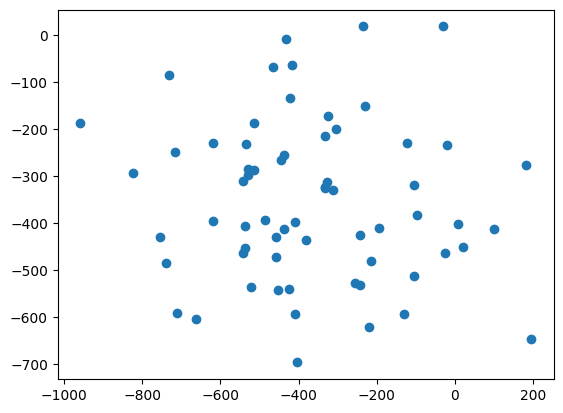

In [165]:
__y=(out*width+offset).detach().cpu().numpy()
__x=(y*width+offset).detach().cpu().numpy()
plt.scatter(__x,__y)

In [166]:
abs(__y-__x).mean()

244.78299

In [47]:
out

tensor([ 0.8180, -1.3554, -1.4370, -0.7086,  0.9014,  0.9481, -0.4938,  0.5365,
         0.4769, -0.3613, -0.0736,  1.7695,  0.2907, -0.9655,  0.8414, -0.8344,
        -0.0066, -1.9910, -1.0272,  0.8579, -1.0235,  0.4143, -0.0443, -0.9343,
         1.3588, -0.7798, -0.9609, -0.9640,  0.6799, -0.8485,  0.7278, -0.8806,
         0.2566,  0.3534, -0.8474, -0.0990, -0.0252,  0.0572, -0.0542,  0.1146,
         0.1543,  0.2626, -0.8576,  0.7496,  0.2906, -1.0026, -0.9187, -0.3129,
         1.2712, -0.0573, -0.6160,  0.0357,  0.4616, -0.0811, -0.6836, -0.0688,
        -0.1598, -0.4604,  0.3033, -0.5491,  0.0073, -0.0317, -0.0783, -0.0235],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [197]:
results_rgin_series=pd.Series(results_rgin)
results_rgcn_series=pd.Series(results_rgcn)
truths_series=pd.Series(truths)

In [ ]:
len(qm9)

In [29]:
import uuid
import inspect
import datetime


'250204'

In [125]:
def save_model(
    name, 
    model, 
    optimizer=None, 
    scheduler=None, 
    hyperparameters=None, 
    arch=None, 
    last_epoch=None,
    last_loss=None, 
    last_loss_metric=None, 
    last_target_name=None, 
    last_dataset_name=None,
    tag_uuid=True,
    or_tag_date=True,
):
    import inspect
    if tag_uuid:
        import uuid
        name=name+'-'+uuid.uuid4().hex[:6]
    elif or_tag_date:
        import datetime
        suffix=datetime.datetime.now().strftime("%y%m%d")
        name=name+'-'+suffix
    if os.path.exists(os.path.join('saves',name)):
        raise FileExistsError("File/dir already exists")
    os.makedirs(os.path.join('saves',name))
    #with open(os.path.join('saves',name,"source_code.py")) as f:
    #    f.write(inspect.getsource(instance))
    checkpoint = {
        'last_epoch': last_epoch,  # current training epoch
        'last_loss': last_loss,  # current training epoch
        'last_loss_metric': last_loss_metric,  # current training epoch
        'last_target_name': last_target_name,  # current training epoch
        'arch': arch,  # current training epoch
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer is not None else None,
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
        'config': model.get_config(),  # a dict of hyperparameters
        'arch': arch if arch is not None else str(type(model)),      # e.g., obtained via subprocess from git
        # Optionally add any additional info (loss, metrics, etc.)
    }
    
    torch.save(checkpoint, os.path.join('saves',name,'checkpoint.pth'))

In [128]:
def load_model(name,cls):
    checkpoint=torch.load(os.path.join('saves',name,'checkpoint.pth'))
    instance:nn.Module = cls.from_config(checkpoint['config'])
    instance.load_state_dict(checkpoint['model_state_dict'])
    return instance

In [152]:
from models.rgin import RGIN

In [151]:
save_model(f"rgin-before-sleep-with-anchor-ang-100kp", rgin,
           last_loss_metric='MSE',last_loss=0.21,
           tag_uuid=False, optimizer=rgin_optimizer,
           last_target_name='normalized_u0',last_dataset_name='qm9',
          )
save_model(f"rgcn-before-sleep-100kp", rgcn,
           last_loss_metric='MSE',last_loss=0.27,
           tag_uuid=False, optimizer=rgcn_optimizer,
           last_target_name='normalized_u0',last_dataset_name='qm9',
          )

In [163]:
rgin2=load_model(f"rgin-before-sleep-with-anchor-ang-100kp-250205", RGIN).cuda()
rgcn2=load_model(f"rgcn-before-sleep-100kp-250205", RGCN).cuda()

tensor([0.1231], device='cuda:0')

In [145]:
_norm

In [158]:
from models.rgin import RGIN

In [159]:
RGIN.from_config(rgin.get_config()).load_state_dict(rgin.state_dict())

<All keys matched successfully>

In [ ]:
from_qm9_pretrained

In [328]:
truths_series.shape,results_xgcn_series.shape,results_rgcn_series.shape

((133184,), (133184,), (133184,))

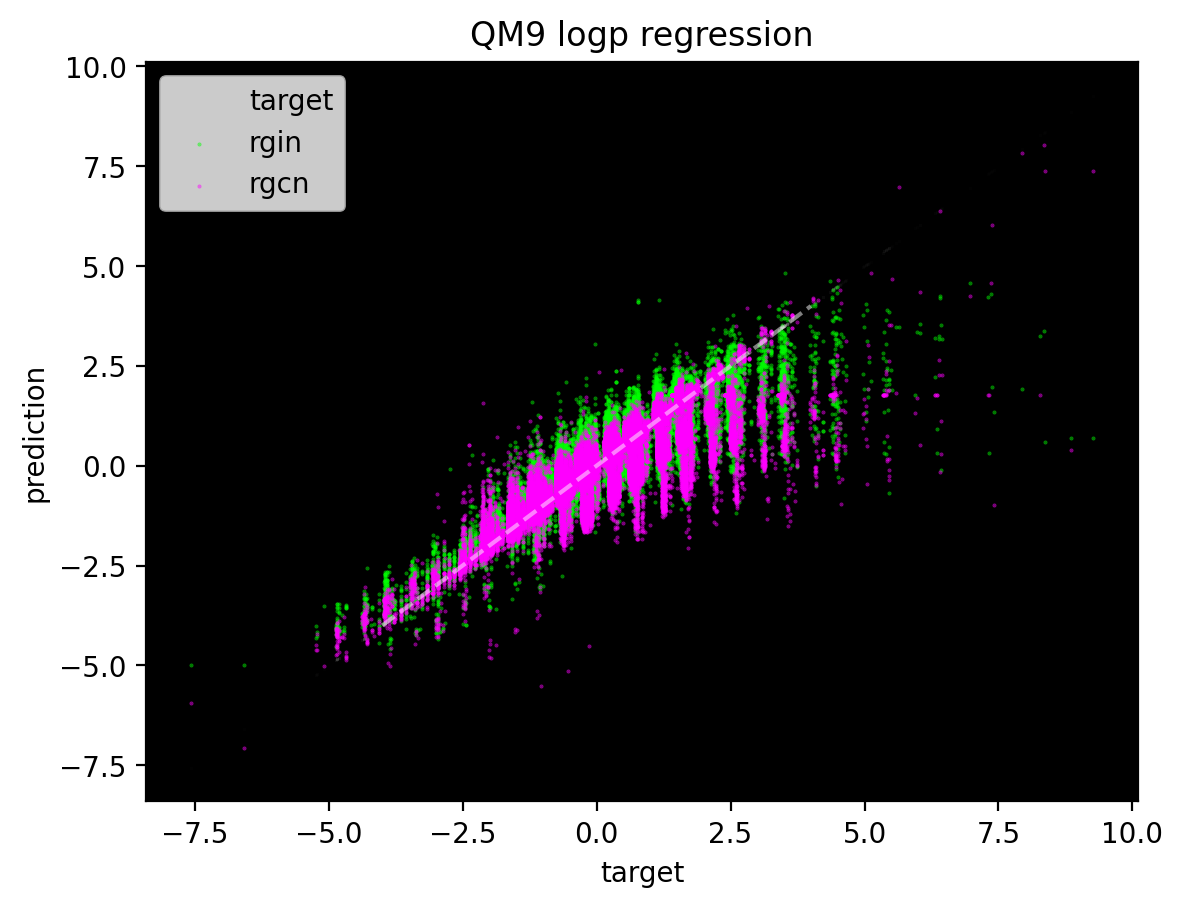

In [184]:
plt.plot((-4,4),(-4,4),linestyle='--',c='#fff',alpha=0.5)
plt.scatter(truths_series,truths_series,label='target',c='#fff',s=0.2,alpha=0.01)
plt.scatter(truths_series,results_rgin_series,label='rgin',c='#0f0',s=0.2,alpha=0.52)
plt.scatter(truths_series,results_rgcn_series,label='rgcn',c='#f0f',s=0.2,alpha=0.52)
plt.xlabel("target")
plt.ylabel("prediction")
plt.legend()
plt.title("QM9 logp regression")
plt.gca().set_facecolor('black')
plt.gcf().set_dpi(200)

In [207]:
mae_rgin=((truths_series-results_rgin_series)).abs().mean()
mse_rgin=((truths_series-results_rgin_series)**2).mean()
mae_rgcn=((truths_series-results_rgcn_series)).abs().mean()
mse_rgcn=((truths_series-results_rgcn_series)**2).mean()
print(f"MAE RGIN: {mae_rgin:.3f}")
print(f"MAE RGCN: {mae_rgcn:.3f}")
print(f"MSE RGIN: {mse_rgin:.3f}")
print(f"MSE RGCN: {mse_rgcn:.3f}")


MAE RGIN: 0.317
MAE RGCN: 0.288
MSE RGIN: 0.204
MSE RGCN: 0.247


In [143]:
1.1**(len(record_loss_schnet)-.5)

25604.77532386932

In [199]:
25229

0.2875789506995091

0.24677050828626682

Text(0.5, 1.0, "QM9 logp regression (delta's pdf)")

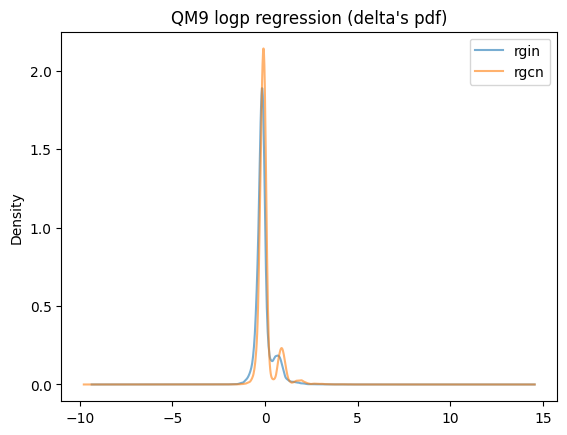

In [176]:
(truths_series-results_rgin_series).plot.kde(label='rgin', alpha=0.6)
(truths_series-results_rgcn_series).plot.kde(label='rgcn', alpha=0.6)
plt.legend()
plt.title("QM9 logp regression (delta's pdf)")

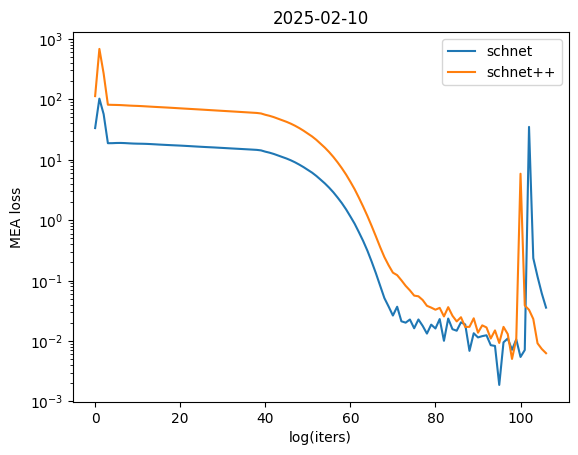

In [136]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d")
plt.plot((record_loss_schnet),label='schnet')
plt.plot((record_loss_schnet2),label='schnet++')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("log(iters)")
plt.gcf().savefig(f"loss_record-{ts}.svg")

In [137]:
plt.plot((record_loss_rgin),label='xgcn')
plt.plot((record_loss_rgcn),label='rgcn')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
#plt.yscale('log')
plt.legend()
plt.title("2025/02/10")

NameError: name 'record_loss_rgin' is not defined

In [138]:
plt.plot((record_loss_xgcn),label='xgcn')
plt.plot((record_loss_rgcn),label='rgcn')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
#plt.yscale('log')
plt.legend()
plt.title("2025/02/10")

NameError: name 'record_loss_xgcn' is not defined

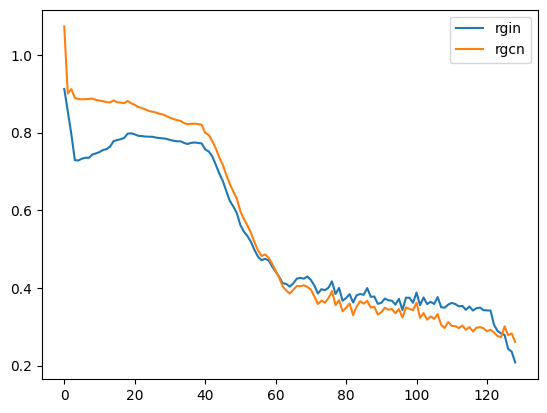

In [26]:
plt.plot((record_loss_rgin),label='rgin')
plt.plot((record_loss_rgcn),label='rgcn')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
#plt.yscale('log')
plt.legend()

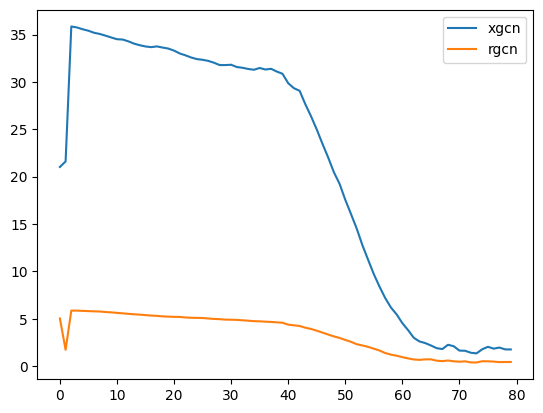

In [87]:
plt.plot(record_loss_xgcn,label='xgcn')
plt.plot(record_loss_rgcn,label='rgcn')
plt.legend()

```python
class MessagePassing(torch.nn.Module):

    special_args: Set[str] = {
        'edge_index', 'adj_t', 'edge_index_i', 'edge_index_j', 'size',
        'size_i', 'size_j', 'ptr', 'index', 'dim_size'
    }

    # Supports `message_and_aggregate` via `EdgeIndex`.
    # TODO Remove once migration is finished.
    SUPPORTS_FUSED_EDGE_INDEX: Final[bool] = False

    def __init__(
        self,
        aggr: Optional[Union[str, List[str], Aggregation]] = 'sum',
        *,
        aggr_kwargs: Optional[Dict[str, Any]] = None,
        flow: str = "source_to_target",
        node_dim: int = -2,
        decomposed_layers: int = 1,
    ) -> None:
        super().__init__()

        if flow not in ['source_to_target', 'target_to_source']:
            raise ValueError(f"Expected 'flow' to be either 'source_to_target'"
                             f" or 'target_to_source' (got '{flow}')")

        # Cast `aggr` into a string representation for backward compatibility:
        self.aggr: Optional[Union[str, List[str]]]
        if aggr is None:
            self.aggr = None
        elif isinstance(aggr, (str, Aggregation)):
            self.aggr = str(aggr)
        elif isinstance(aggr, (tuple, list)):
            self.aggr = [str(x) for x in aggr]

        self.aggr_module = aggr_resolver(aggr, **(aggr_kwargs or {}))
        self.flow = flow
        self.node_dim = node_dim

     
    # Message Passing #########################################################

[docs]
    def forward(self, *args: Any, **kwargs: Any) -> Any:
        r"""Runs the forward pass of the module."""


[docs]
    def propagate(
        self,
        edge_index: Adj,
        size: Size = None,
        **kwargs: Any,
    ) -> Tensor:
        decomposed_layers = 1 if self.explain else self.decomposed_layers

        for hook in self._propagate_forward_pre_hooks.values():
            res = hook(self, (edge_index, size, kwargs))
            if res is not None:
                edge_index, size, kwargs = res

        mutable_size = self._check_input(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        fuse = False
        if self.fuse and not self.explain:
            if is_sparse(edge_index):
                fuse = True
            elif (not torch.jit.is_scripting()
                  and isinstance(edge_index, EdgeIndex)):
                if (self.SUPPORTS_FUSED_EDGE_INDEX
                        and edge_index.is_sorted_by_col):
                    fuse = True

        if fuse:
            coll_dict = self._collect(self._fused_user_args, edge_index,
                                      mutable_size, kwargs)

            msg_aggr_kwargs = self.inspector.collect_param_data(
                'message_and_aggregate', coll_dict)
            for hook in self._message_and_aggregate_forward_pre_hooks.values():
                res = hook(self, (edge_index, msg_aggr_kwargs))
                if res is not None:
                    edge_index, msg_aggr_kwargs = res
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)
            for hook in self._message_and_aggregate_forward_hooks.values():
                res = hook(self, (edge_index, msg_aggr_kwargs), out)
                if res is not None:
                    out = res

            update_kwargs = self.inspector.collect_param_data(
                'update', coll_dict)
            out = self.update(out, **update_kwargs)

        else:  # Otherwise, run both functions in separation.
            if decomposed_layers > 1:
                user_args = self._user_args
                decomp_args = {a[:-2] for a in user_args if a[-2:] == '_j'}
                decomp_kwargs = {
                    a: kwargs[a].chunk(decomposed_layers, -1)
                    for a in decomp_args
                }
                decomp_out = []

            for i in range(decomposed_layers):
                if decomposed_layers > 1:
                    for arg in decomp_args:
                        kwargs[arg] = decomp_kwargs[arg][i]

                coll_dict = self._collect(self._user_args, edge_index,
                                          mutable_size, kwargs)

                msg_kwargs = self.inspector.collect_param_data(
                    'message', coll_dict)
                
                out = self.message(**msg_kwargs)
                
                aggr_kwargs = self.inspector.collect_param_data(
                    'aggregate', coll_dict)
                
                out = self.aggregate(out, **aggr_kwargs)
                
                update_kwargs = self.inspector.collect_param_data(
                    'update', coll_dict)
                out = self.update(out, **update_kwargs)


        return out


[docs]
    def message(self, x_j: Tensor) -> Tensor:
        return x_j


[docs]
    def aggregate(
        self,
        inputs: Tensor,
        index: Tensor,
        ptr: Optional[Tensor] = None,
        dim_size: Optional[int] = None,
    ) -> Tensor:
        return self.aggr_module(inputs, index, ptr=ptr, dim_size=dim_size,
                                dim=self.node_dim)


[docs]
    @abstractmethod
    def message_and_aggregate(self, edge_index: Adj) -> Tensor:
        raise NotImplementedError


[docs]
    def update(self, inputs: Tensor) -> Tensor:
        return inputs
```

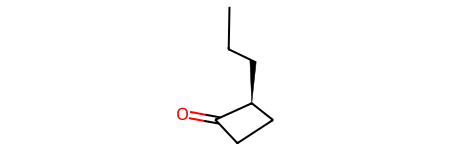

In [74]:
import numpy as np
i=np.random.randint(133885)
E,X,A,y=process_molecule_dense(Chem.SDMolSupplier("gdb9.sdf")[i])
x=X
edge_index=A.nonzero().T
edge_attr=E[edge_index[0],edge_index[1]].T
Chem.SDMolSupplier("gdb9.sdf")[i]

In [75]:
xgcn_dense(E,X,A)

H.mean(0) = tensor([ 0.5193,  0.3828,  1.3413, -0.6874, -0.4574], device='cuda:0',
       grad_fn=<MeanBackward1>)
H.mean(0) = tensor([-0.9487,  0.9612,  0.9578, -0.9240,  0.5335], device='cuda:0',
       grad_fn=<MeanBackward1>)
H.mean(0) = tensor([-0.5096, -0.5287, -0.1639,  0.9398, -0.5359], device='cuda:0',
       grad_fn=<MeanBackward1>)
H.mean(0) = tensor([-0.3135, -0.4466,  0.6920, -0.6009, -0.0867], device='cuda:0',
       grad_fn=<MeanBackward1>)


tensor(-0.0267, device='cuda:0', grad_fn=<MulBackward0>)

In [76]:
xgcn_sparse(x=x, edge_index=edge_index, edge_attr=edge_attr)

h.mean(0) = tensor([ 0.5193,  0.3828,  1.3413, -0.6874, -0.4574], device='cuda:0',
       grad_fn=<MeanBackward1>)
h.mean(0) = tensor([-0.9434,  0.9591,  0.9553, -0.9170,  0.4925], device='cuda:0',
       grad_fn=<MeanBackward1>)
h.mean(0) = tensor([-0.4131, -0.5703, -0.2310,  0.9363, -0.5622], device='cuda:0',
       grad_fn=<MeanBackward1>)
h.mean(0) = tensor([-0.4091, -0.4291,  0.6783, -0.5734, -0.0574], device='cuda:0',
       grad_fn=<MeanBackward1>)


tensor(0.0275, device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
import numpy as np
e_bar=tqdm(range(5))
sup=Chem.SDMolSupplier("gdb9.sdf")
N_mols=133885
for epoch in e_bar:
    try:
        i=np.random.randint(N_mols)
        m=sup[i]
        E,X,A,y=process_molecule_dense(m)
        out=xgcn_dense(E,X,A)
        loss=((out-y)**2).mean()
        xgcn.zero_grad(set_to_none=True)
        loss.backward()
        xgcn_dense_optimizer.step()
        e_bar.set_description(f"{1000*loss.item():60.2f}")
    except Exception as e:
        print("error on",i,e)
        

In [20]:
e_bar=tqdm(range(1000))
sup=Chem.SDMolSupplier("gdb9.sdf")
preds=[]
ys=[]
errs=[]
for e in e_bar:
    try:
        i=np.random.randint(N_mols)
        m=sup[i]
        E,X,A,y=process_molecule_dense(m)
        with torch.no_grad():
            out=xgcn(E,X,A)
        preds.append(out.item())
        ys.append(y)
    except Exception as e:
        errs.append(e)
print("#err:",len(errs))
preds=pd.Series(preds)
ys=pd.Series(ys)

  0%|          | 0/1000 [00:00<?, ?it/s]

#err: 4


<Axes: ylabel='Frequency'>

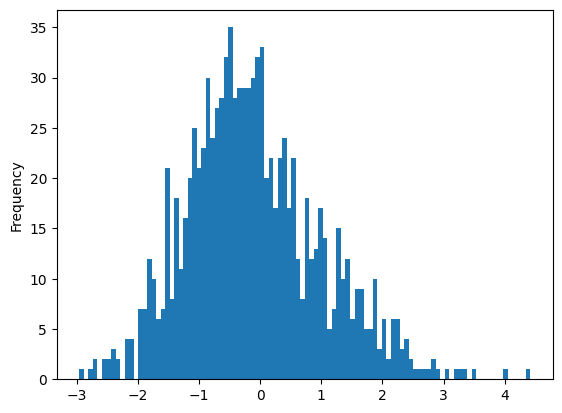

In [21]:
(preds-ys).plot.hist(bins=100)

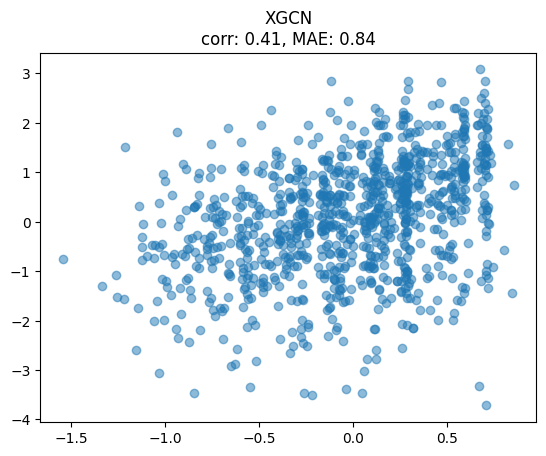

In [22]:
plt.scatter(preds,ys,marker='o',alpha=0.5)
plt.title("XGCN\ncorr: 0.41, MAE: 0.84")

In [128]:
model(*process_molecule_dense(i)[:3])#[1].sum((-2,-1))

tensor(7.7962, device='cuda:0', grad_fn=<MulBackward0>)

In [103]:
torch.save(model.state_dict(), "XGCN_smol.pth")

In [67]:
for n,i in enumerate(sup):
    if n > -1:
        break

In [45]:
tmp=i.GetAtomWithIdx(0)
conf=i.GetConformer()

In [46]:
for b in i.GetBonds():
    print(b)
    break

In [53]:
def print_pos(p):
    print(p.x,p.y,p.z)
print_pos(conf.GetAtomPosition(2))
print_pos(conf.GetAtomPosition(1))
print_pos(conf.GetAtomPosition(2)-conf.GetAtomPosition(1))

1.0718 -0.6526 -0.0111
0.0465 -0.0117 0.0012
1.0253 -0.6408999999999999 -0.0123


In [60]:
(conf.GetAtomPosition(2)-conf.GetAtomPosition(1)).Length()

1.2091915439664638

```python
class OldXGCNConv(MessagePassing):
    def __init__(
        self,
        mlp_dims_node: List[int],
        mlp_dims_edge: List[int],
        aggr: str = 'sum',
        dropout_rate: float = 0.0,
        **kwargs
    ):
        kwargs.setdefault('aggr', aggr)
        super().__init__(node_dim=0, **kwargs)

        self.node_dimses = mlp_dims_node
        self.edge_dimses = mlp_dims_edge

        self.node_mlp = MLP(mlp_dims_node[0], mlp_dims_node[1:-1], mlp_dims_node[-1], dropout_rate=dropout_rate)
        self.edge_mlp = MLP(mlp_dims_edge[0], mlp_dims_edge[1:-1], mlp_dims_edge[-1], dropout_rate=dropout_rate)
         
    def forward(self, x: Tensor,
                edge_index: Adj, edge_attr: Tensor):
        #edge_attr: (typ, dist), |e|
        #edge_index: 2, |e|
        #print("edge_attr:",edge_attr.shape)
        edge_attr = self.edge_mlp(edge_attr)
        #print("edge_attr")
        size = (x.size(0), x.size(0))

        out = torch.zeros(x.size(0), self.node_dimses[-1], device=x.device)
        
        for i in range(self.edge_dimses[-1]):
            h = self.propagate(edge_index, edge_attr=edge_attr, x=x,
                               size=size, i=i)
            h2=self.node_mlp(h)
            out = out + h2
        return out
        
    def message(self, x_j: Tensor, edge_attr, i) -> Tensor:
        return x_j*edge_attr[:,i].view(-1,1)

        
class XGCN(nn.Module):
    def __init__(self, node_dimses, edge_dimses, dropout_rate=0.0, aggr: str = 'sum'):
        super().__init__()
        self.atom_type_emb = nn.Embedding(117,15)
        self.bond_type_emb = nn.Embedding(22,22)
        self.xgcns = nn.ModuleList([
            XGCNConv(mlp_dims_node, mlp_dims_edge, dropout_rate=dropout_rate, aggr=aggr)
            for mlp_dims_node, mlp_dims_edge in zip(node_dimses, edge_dimses)
        ])
        
    def forward(self, 
                x: Tensor,      
                edge_index: Adj,
                edge_attr: Tensor
                batch=None):
        h = self.atom_type_emb(x)
        edge_attr = torch.cat([
            self.bond_type_emb(edge_attr[:,0].long()), 
            edge_attr[:,1:2]
        ],-1)
        for xgcn in self.xgcns:
            h = xgcn(h, edge_index, edge_attr).tanh()
        if batch is not None:
            return 4.5*scatter(h,batch,dim=0,reduce='mean').mean(-1)
        return 4.5*h.mean((-1,-2))
```

In [218]:
!pwd

/c/Users/umarzein/Desktop/biocheminformatics
